In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import batoid
from batoid.utils import normalized
import matplotlib.pyplot as plt
import ipyvolume as ipv
import numpy as np

In [3]:
batoid.datadir = '/home/bregeon/LSST/CCOB/batoid_ghosts/batoid/data'
telescope = batoid.Optic.fromYaml("LSST_CCOB_r.yaml")

In [4]:
# Make refractive interfaces partially reflective
for surface in telescope.itemDict.values():
    if isinstance(surface, batoid.RefractiveInterface):
        surface.forwardCoating = batoid.SimpleCoating(0.02, 0.98)
        surface.reverseCoating = batoid.SimpleCoating(0.02, 0.98)
    if isinstance(surface, batoid.Detector):
        surface.forwardCoating = batoid.SimpleCoating(0.02, 0.98)

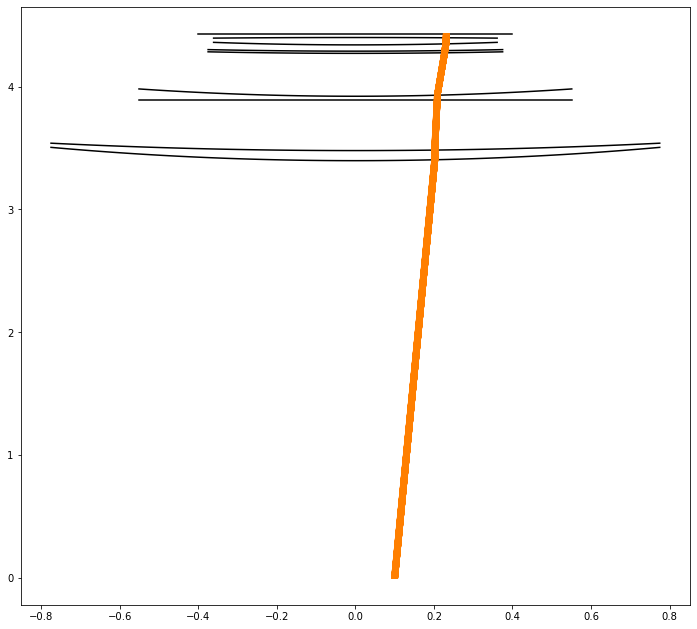

In [5]:
fig1 = plt.figure(figsize=(12, 11))
ax1 = fig1.add_subplot(111)
telescope.draw2d(ax1, c='k')

c = '#ff7f00'
rays = []

n = 1000
r = np.random.uniform(low=0, high=0.00005, size=n)  # radius
theta = np.random.uniform(low=0, high=2*np.pi, size=n)  # angle

source_x = np.sqrt(r) * np.cos(theta) + 0.1
source_y = np.sqrt(r) * np.sin(theta) + 0.1

for px, py in zip(source_x, source_y):
    p0 = np.array([px, py, 0])
    v = normalized(np.array([0.03, 0., 1]))/1.000277
    ray = batoid.Ray(p0, v, t=0, wavelength=500e-9)
    p0 = ray.positionAtTime(0)
    rays.append(batoid.Ray(p0, v, t=0, wavelength=500e-9))

src_vector = batoid.RayVector(rays)
rForward, rReverse = telescope.traceSplit(batoid.RayVector(rays), minFlux=1e-4)
traceFull = telescope.traceFull(batoid.RayVector(rays))
batoid.drawTrace2d(ax1, traceFull, c=c)


ValueError: First argument must be a sequence

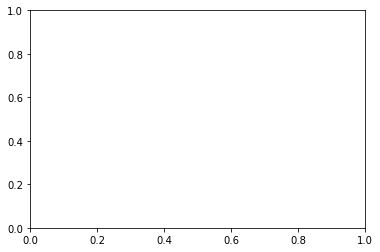

In [6]:
for i, rr in enumerate(rForward):
    plt.hexbin(rr.x, rr.y, extent=[-0.35, 0.35, -0.35, 0.35], gridsize=150)
    # plot approximate focal plane radius
    th = np.linspace(0, 2*np.pi, 1000)
    plt.plot(0.32*np.cos(th), 0.32*np.sin(th), c='r')
    # plot direct path location on focal plane
    # direct path will be rForward with fewest number of things in "path"
    w = np.argmin([len(rrr.path) for rrr in rForward])
    plt.scatter(np.mean(rForward[w].x), np.mean(rForward[w].y), marker='+', color='m')
    plt.gca().set_aspect("equal")
    plt.title(f"ghost {i}")
    plt.show()

In [7]:
all_x = rForward[0].x.tolist()
all_y = rForward[0].y.tolist()
for rr in rForward[1:]:
    all_x = all_x + rr.x.tolist()
    all_y = all_y + rr.y.tolist()

plt.hexbin(all_x, all_y, extent=[-0.35, 0.35, -0.35, 0.35], gridsize=150)
# plot approximate focal plane radius
th = np.linspace(0, 2*np.pi, 1000)
plt.plot(0.32*np.cos(th), 0.32*np.sin(th), c='r')
# plot direct path location on focal plane
# direct path will be rForward with fewest number of things in "path"
w = np.argmin([len(rrr.path) for rrr in rForward])
plt.scatter(np.mean(rForward[w].x), np.mean(rForward[w].y), marker='+', color='m')
plt.gca().set_aspect("equal")
plt.title(f"ghosts")
plt.rcParams["figure.figsize"] = [9, 9]
plt.show()

AttributeError: 'float' object has no attribute 'tolist'

In [8]:
# Pick a few ghosts and look in more detail
ghost = rForward[15]
for item in ghost.path:
    print(item)
plt.hexbin(ghost.x, ghost.y, gridsize=100)
plt.gca().set_aspect('equal')
plt.show()

AttributeError: 'Ray' object has no attribute 'path'

In [9]:
ghost = rForward[25]
for item in ghost.path:
    print(item)
plt.hexbin(ghost.x, ghost.y, gridsize=100)
plt.gca().set_aspect('equal')
plt.show()

AttributeError: 'Ray' object has no attribute 'path'

In [10]:
ghost = rForward[26]
for item in ghost.path:
    print(item)
plt.hexbin(ghost.x, ghost.y, gridsize=100)
plt.gca().set_aspect('equal')
plt.show()

AttributeError: 'Ray' object has no attribute 'path'

In [11]:
ghost = rForward[15]

# polar rays make a bit of a confusing plot
# rays = batoid.RayVector.asPolar(
#     telescope, wavelength=620e-9,
#     theta_x=0.0, theta_y=np.deg2rad(1.5),
#     nrad=10, naz=30
# )



tf = telescope.traceFull(src_vector, _path=ghost.path)

ipv.figure(width=700, height=500)
telescope.draw3d(ipv, color='black')
batoid.drawTrace3d(ipv, tf, c='r')
ipv.xlim(-1, 1)
ipv.ylim(-1, 1)
ipv.zlim(3, 5)
ipv.show()

AttributeError: 'Ray' object has no attribute 'path'